In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math

In [2]:
filename='Lab 5.csv'
headers=['time','ec','k4','k5','rmy','esb','yvr']
dtypes = ['datetime', 'float','float','float','float','float','float']
df = pd.read_csv(filename,names=headers, usecols = [0,1,3,4,5,6,7],header=0)

## Function for corrections

In [3]:
def spatial_gravity(lat,height,mean_height):
    a = 1-((2.6373e-3)*math.cos(2*lat))+((5.9e-6)*(math.cos(2*lat)**2))
    b = ((3.086e-6)*height) + ((1.118e-6)*(height-mean_height))
    c = 9.80616*(a)
    g = c-b
    return g

def inHG_to_kPa(x):
    return (x*101.325)/29.92126

def hPa_to_kPa(x):
    return (x*101.325)/1013.25


UBC_LAT=49.2606
MEAN_HEIGHT=5.182   #meters ASL found using geoid height results
gn=9.80665          #standard acceleration of gravity m/s^2 
Hp= 105             #station elevation in gpm; 
T= 4.53             #current station temp in C
TS= 273.15 + T      #station temperature in K; 
lr= 0.0065          #the assumed lapse-rate in the fictitious air column extending
                    #from sea level to the level of the station elevation level  K/gpm; 

T_time_before = 3.4
local_g=spatial_gravity(UBC_LAT,Hp,MEAN_HEIGHT)
Tv_star=273.15 + (0.5*(T+T_time_before+(Hp*lr)))
sea_level_correction=math.exp(Hp/(29.3*Tv_star))


def sea_level_reduction(p):
    return p*sea_level_correction

def gravity_cor(lat,height,mean_height,raw_p):
    P= (local_g*raw_p)/gn
    return P
        


## Raw data plot

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

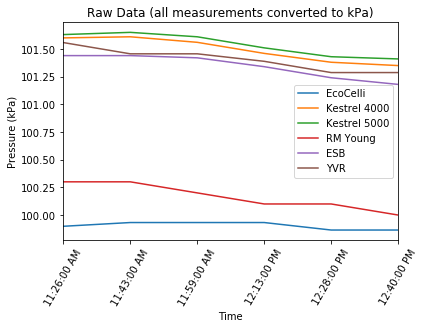

In [4]:
df['ec'] = df['ec'].apply(inHG_to_kPa)
df['yvr'] = df['yvr'].apply(inHG_to_kPa)
df['k4'] = df['k4'].apply(hPa_to_kPa)
df['k5'] = df['k5'].apply(hPa_to_kPa)
df['esb'] = df['esb'].apply(hPa_to_kPa)

df_raw=df.copy()
ax = df_raw.plot(x='time')
ax.set_title('Raw Data (all measurements converted to kPa)')
ax.set_xlabel('Time')
ax.set_ylabel('Pressure (kPa)')
ax.legend(['EcoCelli','Kestrel 4000','Kestrel 5000','RM Young','ESB','YVR'])
plt.xticks(rotation=60)


## Calibrated Data Plot

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

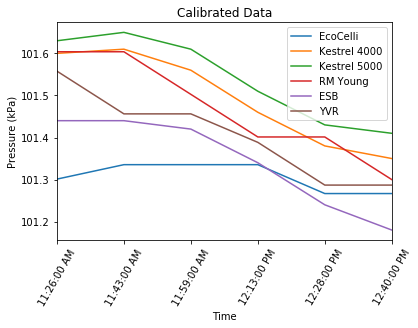

In [5]:
df['ec'] = gravity_cor(UBC_LAT,Hp,MEAN_HEIGHT,df.ec)
df['ec']=df['ec'].apply(sea_level_reduction)
df['rmy']=df['rmy'].apply(sea_level_reduction)

df_cal=df.copy()
ax = df_cal.plot(x='time')
ax.set_title('Calibrated Data')
ax.set_xlabel('Time')
ax.set_ylabel('Pressure (kPa)')
ax.legend(['EcoCelli','Kestrel 4000','Kestrel 5000','RM Young','ESB','YVR'])
plt.xticks(rotation=60)

## Difference Plot

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

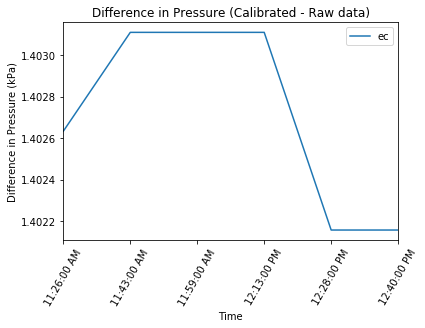

In [6]:
diff=df_cal.copy()
diff['ec']=df_cal.ec-df_raw.ec
diff['k4']=df_cal.k4-df_raw.k4
diff['k5']=df_cal.k5-df_raw.k5
diff['rmy']=df_cal.rmy-df_raw.rmy
diff['esb']=df_cal.esb-df_raw.esb
diff['yvr']=df_cal.yvr-df_raw.yvr

ax= diff.plot(x='time',y='ec')
ax.set_title('Difference in Pressure (Calibrated - Raw data)')
ax.set_xlabel('Time')
ax.set_ylabel('Difference in Pressure (kPa)')
ax.ticklabel_format(useOffset=False,axis='y')
plt.xticks(rotation=60)

## Calculate and plot the variation of sea-level gravitational acceleration with latitude. (Hint, use eq. 3.A.6 from WMO-8 chapter 3, annex 3. A)

$g_(\varphi,0)=9.80620(1-0.0026442*\cos(2\varphi) + 0.0000058 \cos ^2(2\varphi))$

In [7]:
def sea_level_latitude_trend(lats):
    trends=[]
    for l in lats:
        trends.append(one_sl(l))
    return trends

def one_sl(lat):
    return 9.80620*(1-(0.0026442*math.cos(2*lat)) + (0.0000058*(math.cos(2*lat)**2)))

all_lats = np.arange(-90, 90).tolist()
all_trends=sea_level_latitude_trend(all_lats)

Text(0.5,1,'sea-level gravitational acceleration with latitude')

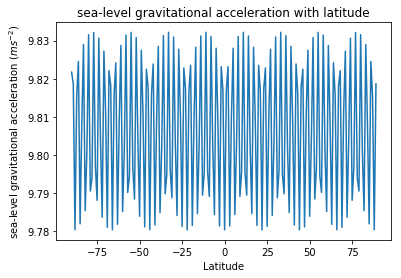

In [8]:
plt.plot(all_lats,all_trends)
plt.xlabel('Latitude')
plt.ylabel('sea-level gravitational acceleration $(ms^{-2})$')
plt.title('sea-level gravitational acceleration with latitude')

For the latitude of UBC, plot local gravitational acceleration g vs elevation H above sea level for 
- (a) over land having terrain elevation of 500 m; /2 
- (b) over the ocean of depth 1 km; and /2 
- (c) at a shoreline at a 50% mix of land from (a) and ocean from (b). /2


(Hint, use slide 30 and eqs. 3.A.7-9 from WMO-8 chapter 3, Annex 3.A)



- (a) $g = g_(\varphi,0)-(0.000003086*z_{stn})+0.000001118*(z_{stn}-z_{avg})$
- (b) $g = g_(\varphi,0)-(0.000003086*z_{stn})+0.00000688*(depth\;below\;station-mean\;depth)$
- (c) $g = g_(\varphi,0)-(0.000003086*z_{stn})+0.000001118*\alpha*(z_{stn}-z_{avg}) - 0.00000688*(1-\alpha)*(depth\;below\;station-mean\;depth)$

In [9]:
MEAN_OCEAN_DEPTH=157
alpha=0.5
def a(heights):
    trends=[]
    for h in heights:
        g = one_sl(UBC_LAT) -(0.000003086*h)+0.000001118*(h-MEAN_HEIGHT)
        trends.append(g)
    return trends

def b(heights):
    trends=[]
    for h in heights:
        g = one_sl(UBC_LAT) -(0.000003086*h)+0.00000688*(1000-MEAN_OCEAN_DEPTH)
        trends.append(g)
    return trends

def c(heights):
    trends=[]
    for h in heights:
        g = one_sl(UBC_LAT) -(0.000003086*h)+0.000001118*alpha*(h-MEAN_HEIGHT)-0.00000688*(1-alpha)*(1000-MEAN_OCEAN_DEPTH)
        trends.append(g)
    return trends


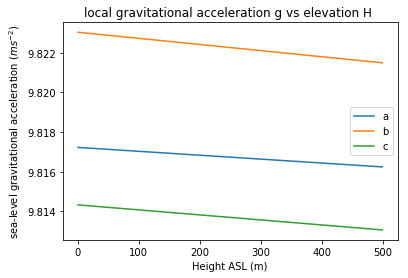

In [10]:
heights = np.arange(0, 500,0.5).tolist()
ga=a(heights)
gb=b(heights)
gc=c(heights)
plt.plot(heights,ga,label='a')
plt.plot(heights,gb,label='b')
plt.plot(heights,gc,label='c')
plt.xlabel('Height ASL (m)')
plt.ylabel('sea-level gravitational acceleration $(ms^{-2})$')
plt.title('local gravitational acceleration g vs elevation H ')
plt.legend()

## Sea Level reduction from WMO equation

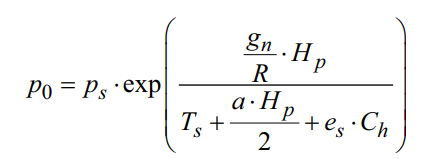

- ps is station pressure (hPa)
- gn is the standard acceleration of gravity = 9.80665 ms–2 
- R is the gas constant of dry air = 287.05 J/kg/K
- Hp is the station elevation in gpm
- Ts is station temp in K
- a is  is the assumed lapse-rate in the fictitious air column extending from sea level to the level of the station elevation level = 0.0065 K/gpm
- es is the vapour pressure at the station in hPa
- Ch is the coefficient = 0.12 K/hPa

In [11]:
RH= 0.9711
R = 287.05
a=0.0065
Ch = 0.12
psat=0.6113*math.exp((17.2694*T)/(T-35.86))
es = RH*psat
num=gn*Hp/R
den=TS+(a*Hp/2)+(es*Ch)
ex = math.exp(num/den)

def sea_level_reduction_WMO(ps):
    return ps*ex
df_WMO=df_raw.copy()
df_WMO['ec'] = gravity_cor(UBC_LAT,Hp,MEAN_HEIGHT,df_WMO.ec)
df_WMO['ec']=df_WMO['ec'].apply(sea_level_reduction_WMO)
df_WMO['rmy']=df_WMO['rmy'].apply(sea_level_reduction_WMO)

In [12]:
df_cal

,time,ec,k4,k5,rmy,esb,yvr
0,11:26:00 AM,101.301084,101.60,101.63,101.603874,101.44,101.557780
1,11:43:00 AM,101.335423,101.61,101.65,101.603874,101.44,101.456189
2,11:59:00 AM,101.335423,101.56,101.61,101.502575,101.42,101.456189
3,12:13:00 PM,101.335423,101.46,101.51,101.401275,101.34,101.388461
4,12:28:00 PM,101.266744,101.38,101.43,101.401275,101.24,101.286869
5,12:40:00 PM,101.266744,101.35,101.41,101.299975,101.18,101.286869


In [13]:
df_WMO

,time,ec,k4,k5,rmy,esb,yvr
0,11:26:00 AM,101.299693,101.60,101.63,101.602480,101.44,101.557780
1,11:43:00 AM,101.334032,101.61,101.65,101.602480,101.44,101.456189
2,11:59:00 AM,101.334032,101.56,101.61,101.501181,101.42,101.456189
3,12:13:00 PM,101.334032,101.46,101.51,101.399882,101.34,101.388461
4,12:28:00 PM,101.265354,101.38,101.43,101.399882,101.24,101.286869
5,12:40:00 PM,101.265354,101.35,101.41,101.298584,101.18,101.286869


(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

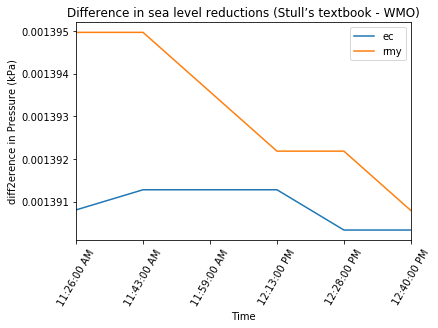

In [14]:
diff2=df_cal.copy()
diff2['ec']=df_cal.ec-df_WMO.ec
diff2['k4']=df_cal.k4-df_WMO.k4
diff2['k5']=df_cal.k5-df_WMO.k5
diff2['rmy']=df_cal.rmy-df_WMO.rmy
diff2['esb']=df_cal.esb-df_WMO.esb
diff2['yvr']=df_cal.yvr-df_WMO.yvr

ax= diff2.plot(x='time',y=['ec','rmy'])
ax.set_title('Difference in sea level reductions (Stull’s textbook - WMO)')
ax.set_xlabel('Time')
ax.set_ylabel('diff2erence in Pressure (kPa)')
ax.ticklabel_format(useOffset=False,axis='y')
plt.xticks(rotation=60)